In [19]:
import numpy as np
import pandas as pd
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [20]:
df = pd.read_csv('Result_Emax_amylase_posthoc_text_separate.csv')

In [21]:
df

,Unnamed: 0,chi2,T,P,P_adjusted,comparitor_1,comparitor_2
0,1,91.632532,-3.536678,0.000,0.000,A_marginata,A_pulchellus
1,2,91.632532,-5.992705,0.000,0.000,A_marginata,A_vanprukii
2,3,91.632532,-2.456027,0.008,0.008,A_pulchellus,A_vanprukii
3,4,91.632532,1.768339,0.041,0.041,A_marginata,B_anceps
4,5,91.632532,5.305018,0.000,0.000,A_pulchellus,B_anceps
...,...,...,...,...,...,...,...
460,461,91.632532,-1.768339,0.041,0.041,R_dumetorum,T_triptera
461,462,91.632532,15.915053,0.000,0.000,R_javanica,T_triptera
462,463,91.632532,-4.322607,0.000,0.000,R_succedanea,T_triptera
463,464,91.632532,12.378375,0.000,0.000,T_loureiri,T_triptera


In [91]:
df = df[['comparitor_1', 'comparitor_2','T','P_adjusted']]

In [24]:
df

,comparitor_1,comparitor_2,T,P_adjusted
0,A_marginata,A_pulchellus,-3.536678,0.000
1,A_marginata,A_vanprukii,-5.992705,0.000
2,A_pulchellus,A_vanprukii,-2.456027,0.008
3,A_marginata,B_anceps,1.768339,0.041
4,A_pulchellus,B_anceps,5.305018,0.000
...,...,...,...,...
460,R_dumetorum,T_triptera,-1.768339,0.041
461,R_javanica,T_triptera,15.915053,0.000
462,R_succedanea,T_triptera,-4.322607,0.000
463,T_loureiri,T_triptera,12.378375,0.000


In [26]:
#remove self correlations
df = df.loc[df['comparitor_1'] != df['comparitor_2']].copy()

In [27]:
#create undirected graph with weights corresponding to the correlation magnitude
G0 = nx.from_pandas_edgelist(df, 'comparitor_1', 'comparitor_2', edge_attr=['T'])

#print out the graph info
#check number of nodes and degrees are as expected (all should have degree = 38, i.e. average degree = 38)
print(nx.info(G0))

Graph with 31 nodes and 465 edges


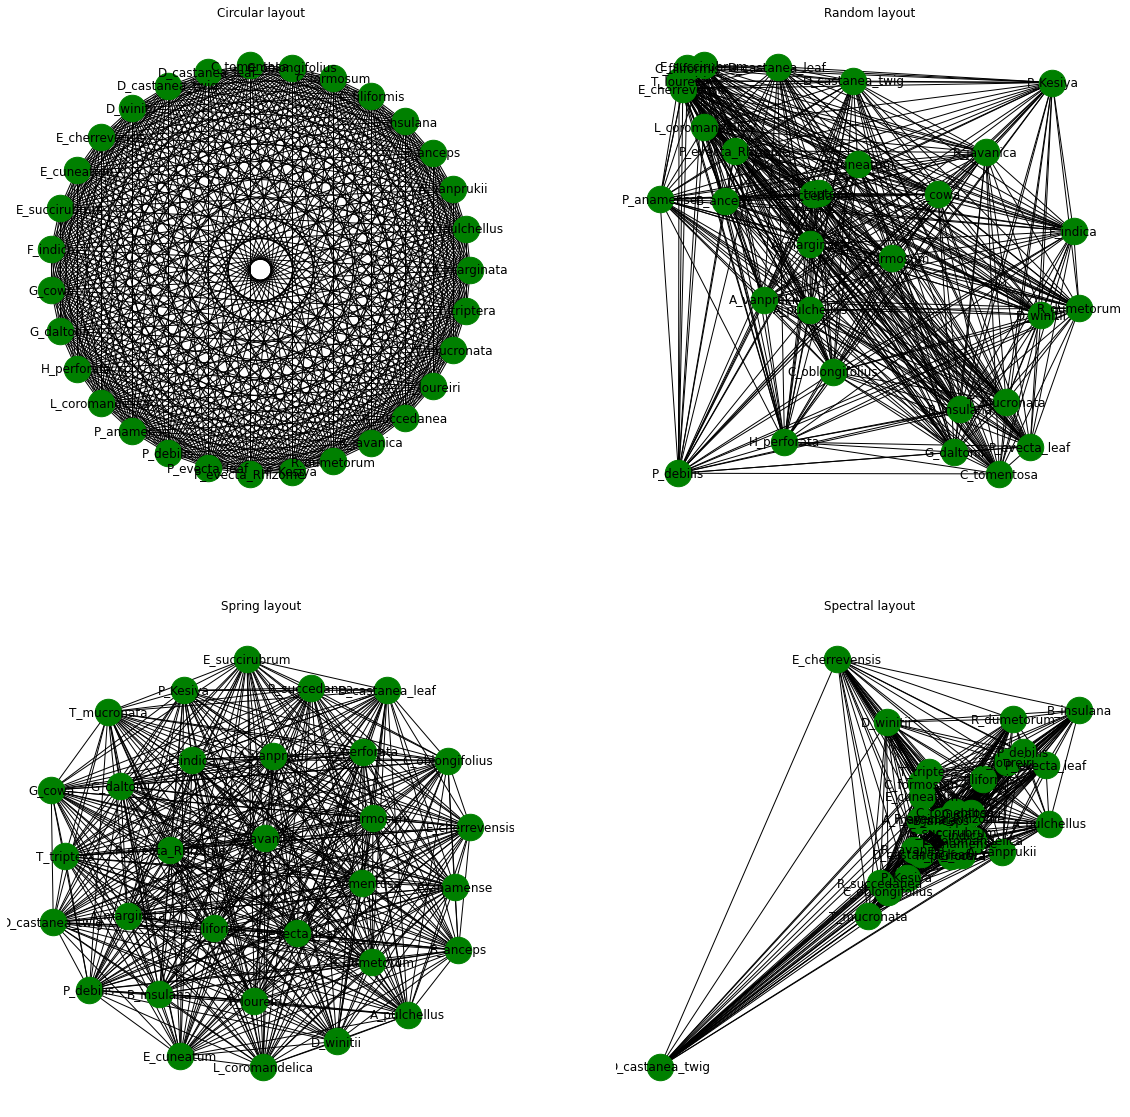

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,20))

nx.draw(G0, with_labels=True, node_size=700, node_color="green",
        edge_color='black',  pos=nx.circular_layout(G0),ax=ax[0,0])
ax[0,0].set_title("Circular layout")

nx.draw(G0, with_labels=True, node_size=700, node_color="green",
        edge_color='black',  pos=nx.random_layout(G0),ax=ax[0,1])
ax[0,1].set_title("Random layout")

nx.draw(G0, with_labels=True, node_size=700, node_color="green",
        edge_color='black',  pos=nx.spring_layout(G0),ax=ax[1,0])
ax[1,0].set_title("Spring layout")

nx.draw(G0, with_labels=True, node_size=700, node_color="green",
        edge_color='black',  pos=nx.spectral_layout(G0),ax=ax[1,1])
ax[1,1].set_title("Spectral layout")

plt.show()

In [88]:
# 'winner takes all' method - set minium correlation threshold to remove some edges from the diagram
threshold = 0.05

# create a new graph from edge list
Gx = nx.from_pandas_edgelist(df, 'comparitor_1', 'comparitor_2', edge_attr=['P'])

# list to store edges to remove
remove = []
# loop through edges in Gx and find correlations which are below the threshold
for comparitor_1, comparitor_2 in Gx.edges():
    P = Gx[comparitor_1][comparitor_2]['P']
    #add to remove node list if abs(corr) < threshold
    if P < threshold:
        remove.append((comparitor_1, comparitor_2))

# remove edges contained in the remove list
Gx.remove_edges_from(remove)

print(str(len(remove)) + " edges removed")

NetworkXError: Invalid edge_attr argument: ['P']

In [81]:
def assign_colour(P_adjusted):
    if P_adjusted <= 0:
        return "red"  # blue
    else:
        return "blue"  # blue


def assign_thickness(P_adjusted, benchmark_thickness=10, scaling_factor=5):
    return benchmark_thickness * abs(P)**scaling_factor


def assign_node_size(degree, scaling_factor=50):
    return degree * scaling_factor


# assign colours to edges depending on positive or negative correlation
# assign edge thickness depending on magnitude of correlation
edge_colours = []
edge_width = []
for key, value in nx.get_edge_attributes(Gx, 'P_adjusted').items():
    edge_colours.append(assign_colour(value))
    edge_width.append(assign_thickness(value))

# assign node size depending on number of connections (degree)
node_size = []
for key, value in dict(G0.degree).items():
    node_size.append(assign_node_size(value))
#color by IC50
color_map = []
for node in G0:
    if node in {'G_cowa', 'P_debilis', 'P_evecta_leaf', 'E_cuneatum', 'E_cherrevensis', 'F_indica', 'P_Kesiya', 'R_javanica', 'C_formosum', 'D_castanea_leaf'
                , 'T_mucronata', 'D_winitii', 'B_insulana'}:
        color_map.append('orange')
    else: 
        color_map.append('green') 

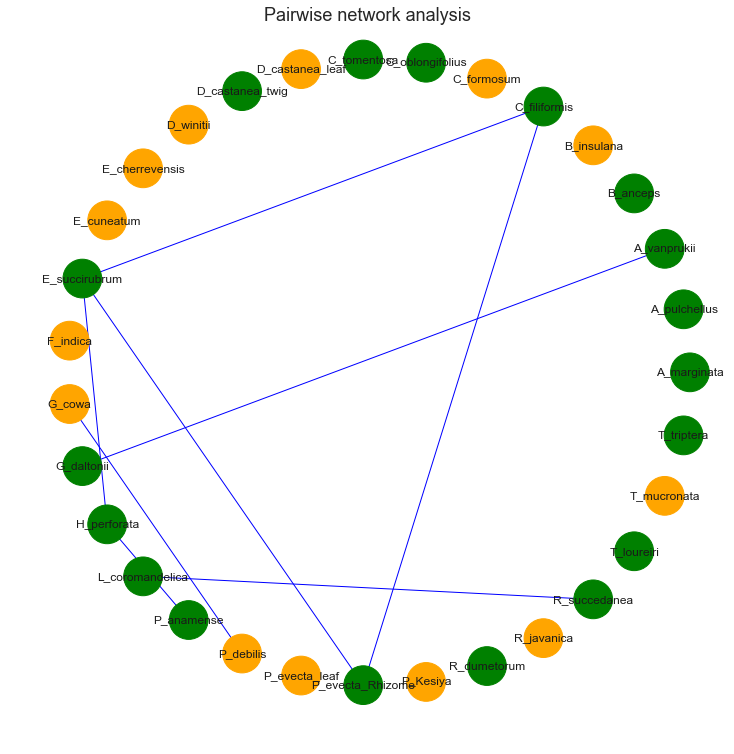

In [82]:
# draw improved graph
sns.set(rc={'figure.figsize': (10, 10)})
font_dict = {'fontsize': 18}

nx.draw(Gx, pos=nx.circular_layout(Gx), with_labels=True,
        node_size=node_size, node_color=color_map, edge_color=edge_colours)

plt.title("Pairwise network analysis", fontdict=font_dict)
plt.savefig('Network _amlyase', dpi=300)
plt.show()

In [84]:
def assign_colour(T):
    if T <= 0:
        return "red"  # blue
    else:
        return "blue"  # blue

edge_colours_all = []

for key, value in nx.get_edge_attributes(G0, 'T').items():
    edge_colours_all.append(assign_colour(value))


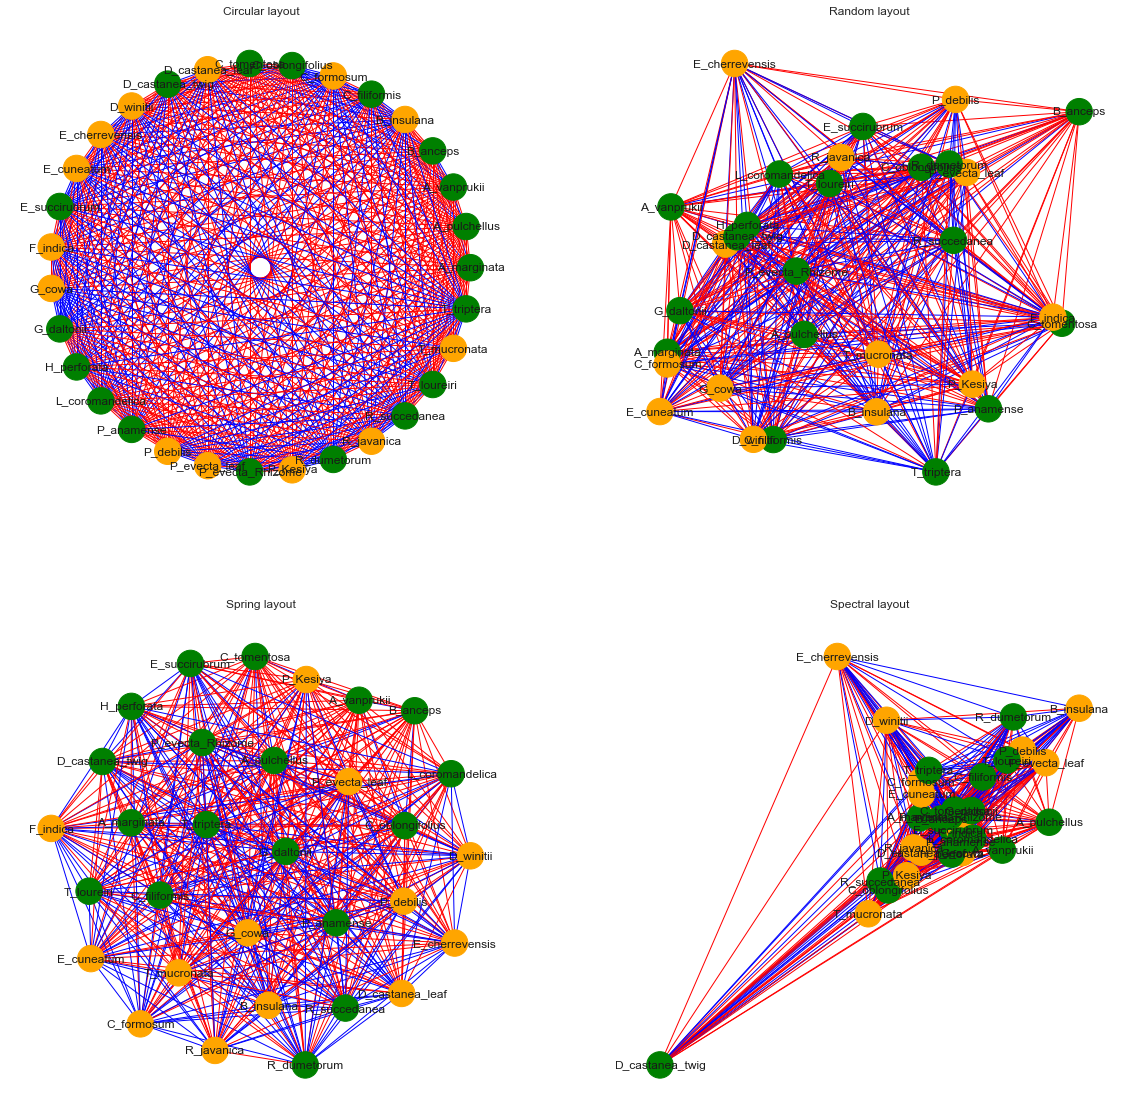

In [87]:

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,20))

nx.draw(G0, with_labels=True, node_size=700,  node_color=color_map, edge_color=edge_colours_all,  pos=nx.circular_layout(G0),ax=ax[0,0])
ax[0,0].set_title("Circular layout")

nx.draw(G0, with_labels=True, node_size=700,  node_color=color_map, edge_color=edge_colours_all,   pos=nx.random_layout(G0),ax=ax[0,1])
ax[0,1].set_title("Random layout")

nx.draw(G0, with_labels=True, node_size=700,  node_color=color_map, edge_color=edge_colours_all,   pos=nx.spring_layout(G0),ax=ax[1,0])
ax[1,0].set_title("Spring layout")

nx.draw(G0, with_labels=True, node_size=700,  node_color=color_map, edge_color=edge_colours_all,   pos=nx.spectral_layout(G0),ax=ax[1,1])
ax[1,1].set_title("Spectral layout")


plt.savefig('Network _amlyase_different_treatment', dpi=300)
plt.show()